# Example of high-level Machine Learning API using dataset G

This notebook demonstrates the use of the high-level API by performing decimal predictions using various machine learning models. A small selection of models and model architectures are chosen based on findings during the thesis work.

When using nothing but the high-level API, a specified recipe should be followed:
1. Define dataset specifics
2. Initiate and divide data
3. Define models
4. Initiate and train models
5. Make predictions

Because the high-level API stores state, the user is exposed to a limited number of return variables and the prediction process is streamlined. For more flexibility and a wider range of functionality, the underlying code library should be used instead of the high-level API.

## Step 0: Import modules

In [1]:
# %load basic_example_G.py
import src.core as mlApi

Using TensorFlow backend.


## Step 1: Define dataset specifics

In [2]:
# File path to dataset .csv file
filename = "../master-thesis-db/datasets/G/data_30min.csv"

# List of columns on form ['name', 'description', 'unit']
columns = [
    ['PDI0064', 'Process Pressure Difference', 'Bar'],
    ['TI0066', 'Process Outlet Temperature','Degrees'],
    ['TZI0012', 'Process Inlet Temperature', 'Degrees'],
    ['FI0010', 'Process Flow Rate', 'M^3/day'],
    ['TT0025', 'Coolant Inlet Temperature', 'Degrees'],
    ['TT0026', 'Coolant Outlet Temperature', 'Degrees'],
    ['PI0001', 'Coolant Inlet Pressure', 'Bar'],
    ['FI0027', 'Coolant Flow Rate', 'M^3/day'],
    ['TIC0022U', 'Coolant Valve Opening', '%'],
    ['PDT0024', 'Coolant Pressure Difference', 'Bar'],
]

# List of column names to ignore completely
irrelevantColumns = [
	'PI0001',
	'FI0027',
	'TIC0022U',
	'PDT0024',
]

# List of column names used a targets
targetColumns = [
	'TT0026',
    'PDI0064',
]

# List of training periods on form ['start', 'end']
traintime = [
	["2019-04-10 00:00:00", "2019-08-01 00:00:00"]
]

# Testing period, recommended: entire dataset
testtime = [
	"2017-01-01 00:00:00",
	"2020-03-01 00:00:00",
]

## Step 2: Initiate and divide data

The user should ensure the desired columns and descriptions are still in the dataset columns after removal. The number of samples matching the provided training and testing periods are displayed.

In [3]:
df = mlApi.initDataframe(filename, columns, irrelevantColumns)
df_train, df_test = mlApi.getTestTrainSplit(traintime, testtime)
X_train, y_train, X_test, y_test = mlApi.getFeatureTargetSplit(targetColumns)

Columns before removal: 
Col. 0 : PDI0064 - Process Pressure Difference
Col. 1 : TI0066 - Process Outlet Temperature
Col. 2 : TZI0012 - Process Inlet Temperature
Col. 3 : FI0010 - Process Flow Rate
Col. 4 : TT0025 - Coolant Inlet Temperature
Col. 5 : TT0026 - Coolant Outlet Temperature
Col. 6 : PI0001 - Coolant Inlet Pressure
Col. 7 : FI0027 - Coolant Flow Rate
Col. 8 : TIC0022U - Coolant Valve Opening
Col. 9 : PDT0024 - Coolant Pressure Difference

Columns after removal: 
Col. 0 : PDI0064 - Process Pressure Difference
Col. 1 : TI0066 - Process Outlet Temperature
Col. 2 : TZI0012 - Process Inlet Temperature
Col. 3 : FI0010 - Process Flow Rate
Col. 4 : TT0025 - Coolant Inlet Temperature
Col. 5 : TT0026 - Coolant Outlet Temperature

Finding data between 2019-04-10 00:00:00 and 2019-08-01 00:00:00
Found 4708 rows

Finding data between 2017-01-01 00:00:00 and 2020-03-01 00:00:00
Found 49290 rows



## Step 3: Define models

A selection of models are available from the src.core module. These include:
- Multilayer perceptron (MLP)
- Long short-term memory (LSTM)
- Gated Recurrent Unit (GRU)
- Linear models
- Tree-based models
- Ensemble models
- Autoencoder models

Parameters for each model and their effect are indicated in the documentation. A set of defaults are used for parameters are not defined by the user. See the thesis for additional details.

In this example, MLP, LSTM and Ensemble models with various architectures are chosen.

In [4]:
mlpd_1x_128 = mlApi.MLP('mlpd 1x 128', layers=[128], dropout=0.2)
lstmd_1x_128 = mlApi.LSTM('lstmd 1x 128', layers=[128], dropout=0.2, recurrentDropout=0.2, enrolWindow=16)
mlpd_2x_64 = mlApi.MLP('mlpd 2x 64', layers=[64, 64], dropout=0.2)
lstmd_2x_64 = mlApi.LSTM('lstmd 2x 64', layers=[64, 64], dropout=0.2, recurrentDropout=0.2, enrolWindow=16)
linear_r = mlApi.Linear_Regularized('linear r')
ensemble1 = mlApi.Ensemble('mlp2 + linear ensemble', [mlpd_2x_64, linear_r])
ensemble2 = mlApi.Ensemble('lstm2 + mlp2 ensemble', [mlpd_2x_64, lstmd_2x_64])

modelList = [
    mlpd_1x_128,
    lstmd_1x_128,
	mlpd_2x_64,
	lstmd_2x_64,
    ensemble1,
    ensemble2,
	linear_r,
]

## Step 4. Initiate and train models

Models are retrained according to the *retrain* parameter. If *retrain* is false while no stored model is found, a new model is trained. Note that models for storage are defined by their **provided model name** and **the output variables** of the model. Input variables and model architecture are not considered when loading stored models. Hence, errors may be encountered if *retrain* is false while a stored model with the same name and output variables are used with difference architectures or input features. See the thesis for furthur explainations.

From the model training, the following output can be seen:
- Indications whether a model was trained or loaded. If trainable methods are not loaded, output describing the learning iterations will be printed according to the previously provided verbose parameters or by default verbose parameters. For linear models, the trained weights will also be displayed
- Table of loss values for each trainable model. The training iteration with the minimum validation loss is chosen
- Plot of loss values for each trainable model. For model convergence, the validation loss should gradually decrease before a minimum point is reached, after which the validation loss should increase slightly before training is aborted

Model mlpd 1x 128 was loaded from file
Model lstmd 1x 128 was loaded from file
Model mlpd 2x 64 was loaded from file
Model lstmd 2x 64 was loaded from file
Model mlp2 + linear ensemble was loaded from file
Training submodel linear r of Ensemble mlp2 + linear ensemble
    Trained weights for linear r:
[[ 0.20940477 -0.14701675 -0.66032295 -0.50420226]
 [ 0.08839097  0.3067797   0.78825993  0.28855551]]
    Trained weights for Linear model of ensemble:
[[ 0.84370091 -0.03806603  0.02609757  0.09553853]
 [ 0.13415493  0.07195526 -0.1627022   0.62865518]]
Model lstm2 + mlp2 ensemble was loaded from file
Model lstm2 + mlp2 ensemble was loaded from file
    Trained weights for Linear model of ensemble:
[[ 0.36664376 -0.00280347  0.6176403   0.0359806 ]
 [-0.13351297  0.13382584  0.07082504  0.81886494]]
Training model linear r
    Trained weights for linear r:
[[ 0.20940477 -0.14701675 -0.66032295 -0.50420226]
 [ 0.08839097  0.3067797   0.78825993  0.28855551]]
+--------------+-----------+--

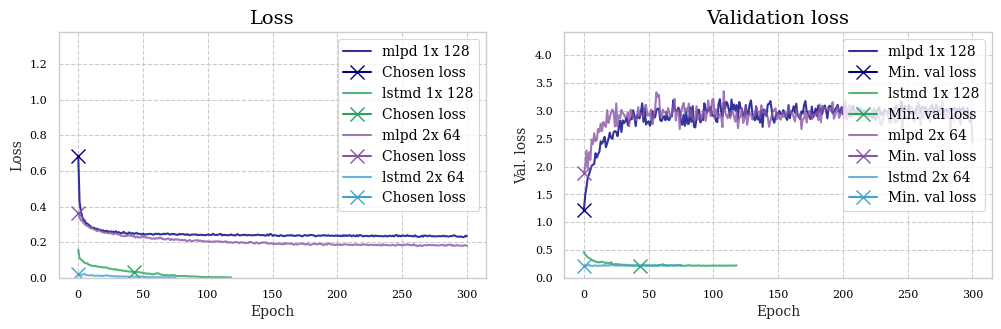

In [5]:
# Define whether to retrain models or not
retrain=False

mlApi.initModels(modelList)
mlApi.trainModels(retrain)

### Remarks regarding model convergence

Notice that neither of the MLP models have converged properly. The chosen validation loss is the same as after the initial epoch, indicating that the models were not capable of learning any past this point. Meanwhile, the LSTM models have converged more successfully, especially the **lstmd 1x 128** model with one hidden layer.

Notice that the weight vector of the linear regressor is significantly less dependent on the Process Flow Rate than e.g. for the *dataset D* linear models. This is logical given the lack of variance in the other features for the simulated dataset. The trained weights for Process Flow Rate of (-0.66) and (0.78) are reasonable when compared to the remaining weights.

## Step 5: Make predictions

Predictions are made for all provided models at once using the *predictWithModels* method. If individual predictions are desired (e.g. for plot readability), the models can be passed individually through a loop.

From the prediction methods, the following output can be seen:
- Table of scores for each method on the training and testing data, using the provided or default loss metric. Note that the test score is not necessarily relevant if a training period of expected deviation is used
- Plot of target values and predicted values for each model, for each output variable
- Plot of deviation between target value and predicted value for each model, for each output variable
- Plot of calculated R2-score on the training set for each model

Model prediction scores
+------------------------+-------------+------------+
|         Model          | Train score | Test score |
+------------------------+-------------+------------+
|      mlpd 1x 128       |    0.3991   |  -0.7978   |
|      lstmd 1x 128      |    0.784    |  -0.9907   |
|       mlpd 2x 64       |    0.3896   |  -1.3923   |
|      lstmd 2x 64       |    0.7865   |  -0.9993   |
| mlp2 + linear ensemble |    0.5937   |  -1.4159   |
| lstm2 + mlp2 ensemble  |    0.8336   |  -1.1393   |
|        linear r        |    0.4868   |  -0.9427   |
+------------------------+-------------+------------+


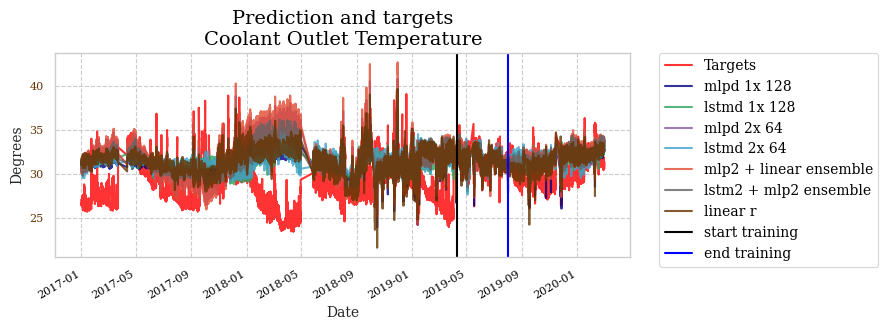

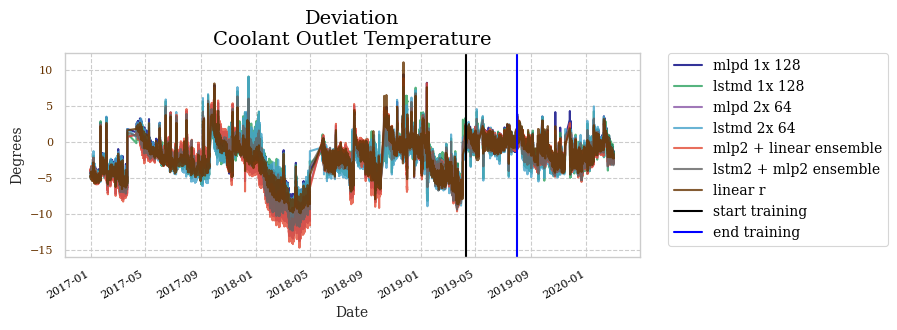

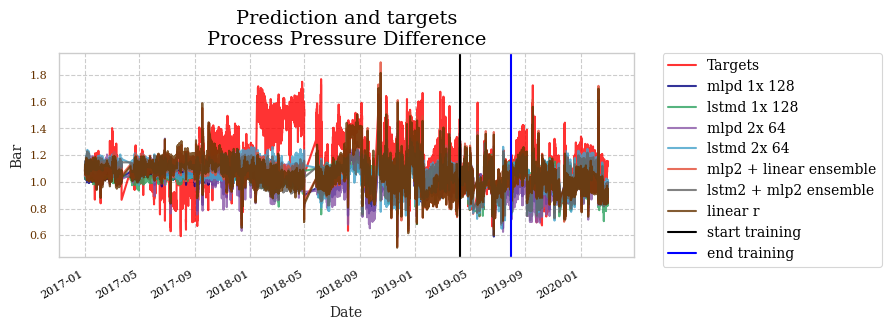

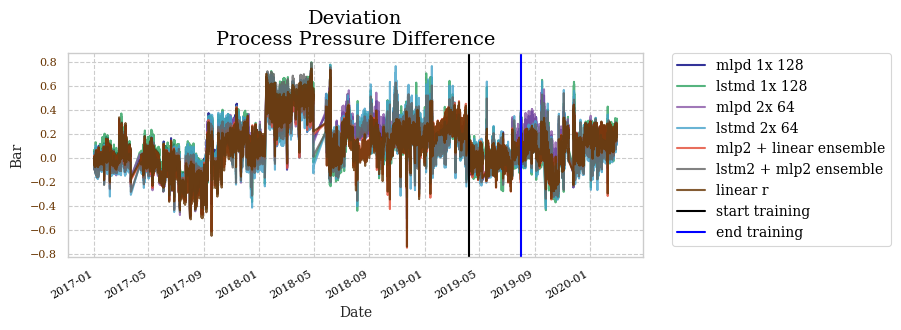

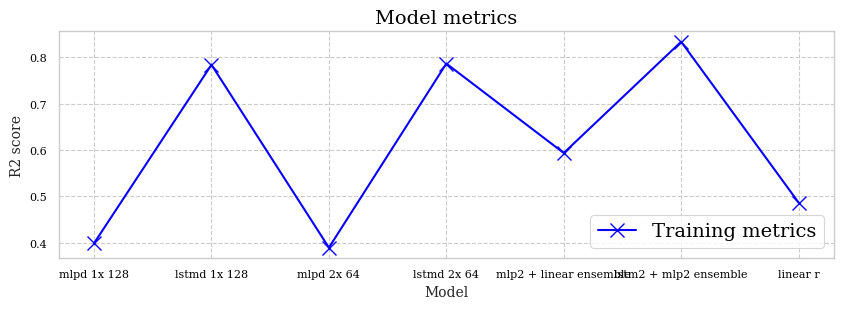

In [6]:
modelNames, metrics_train, metrics_test, columnsList, deviationsList = mlApi.predictWithModels(
	plot=True,
	interpol=False,
	score=True,
)

### Remarks regarding model predictions

The **lstm2 + mlp2** ensemble scores highest, but keeping in mind non of these models seemed to converge to satisfying loss values, it is had to imagine this ensemble being the optimal model choice. Of the remaning models, we see that both the **lstmd 1x 128** and Linear model outscore the MLPs significantly. Predictions seem logical, without the previously seen lack of variance in LSTM predictions.

## Additional plots

The following plots are added for visualization purposes only. Predictions and deviation for each model is printed separately. Note that this is not part of the 'recipe' defined for the high-level API.

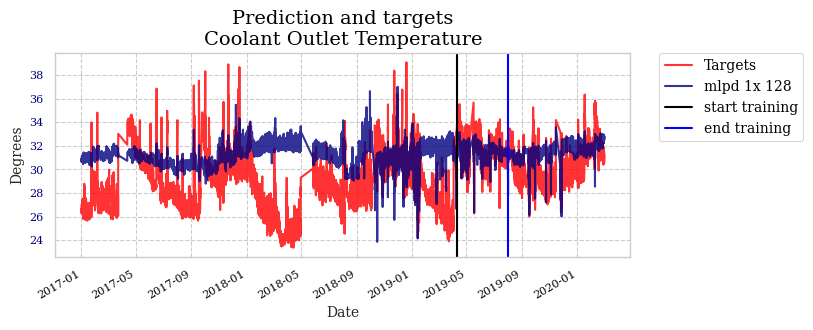

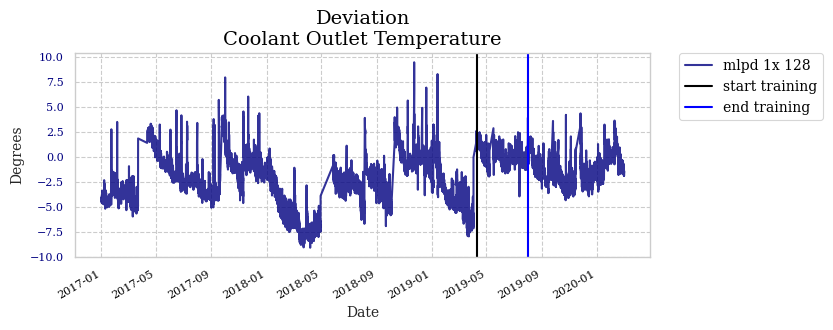

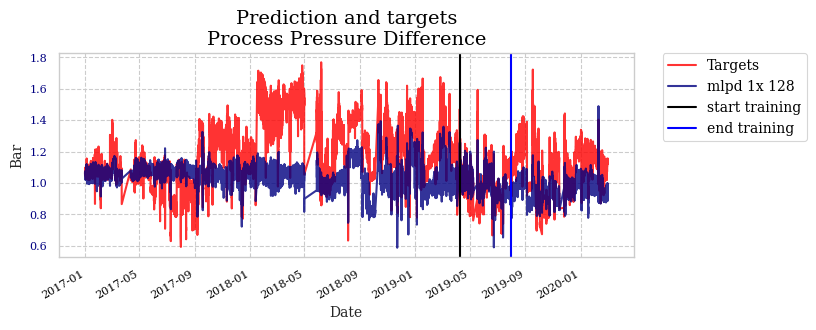

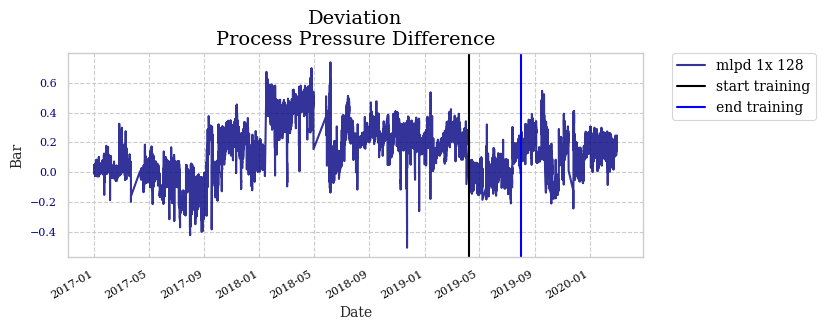

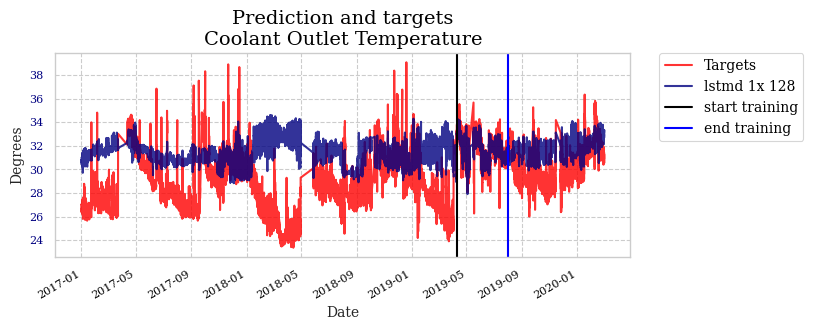

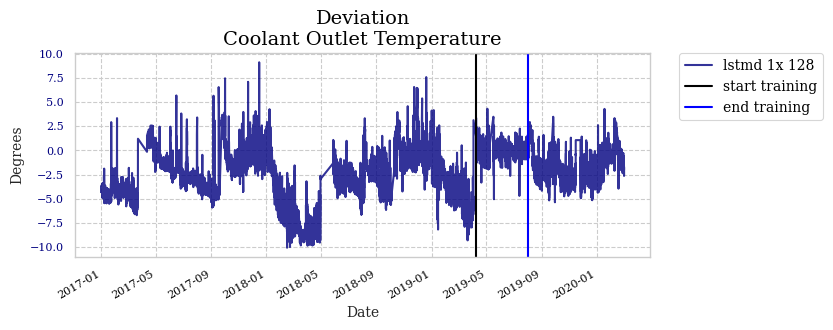

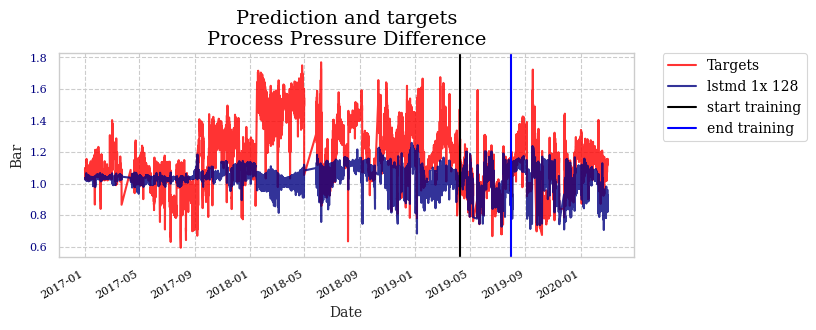

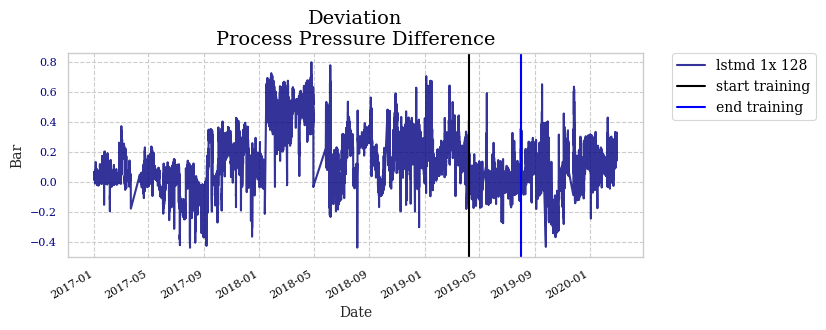

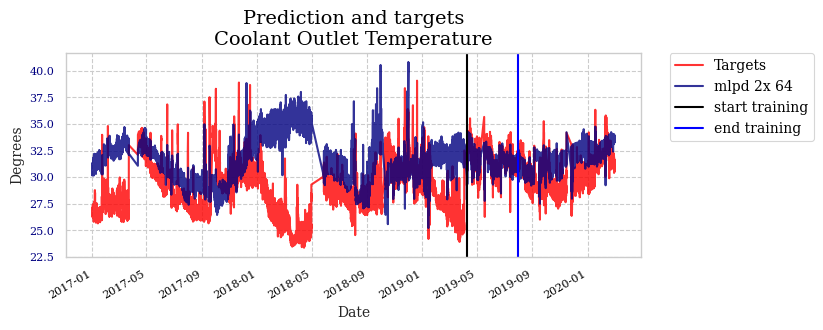

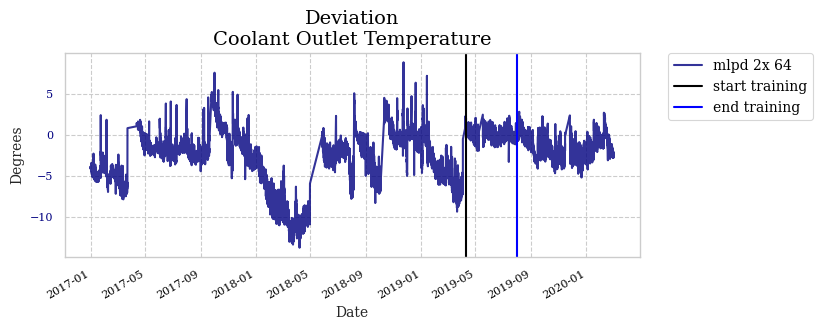

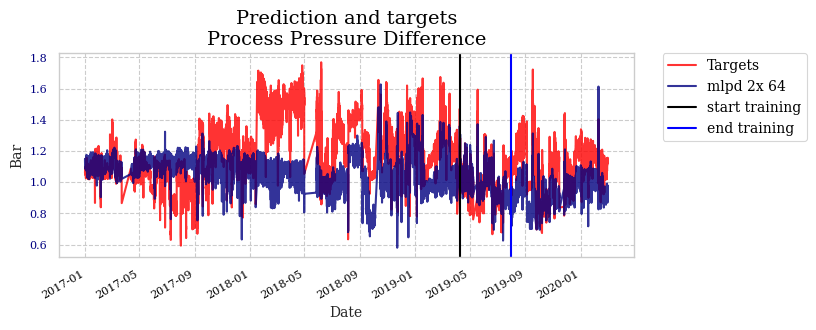

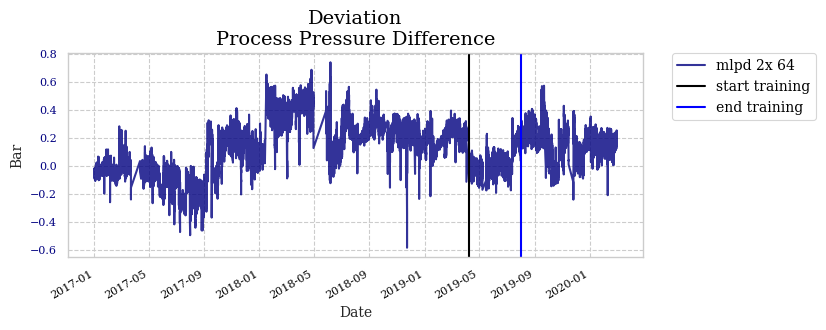

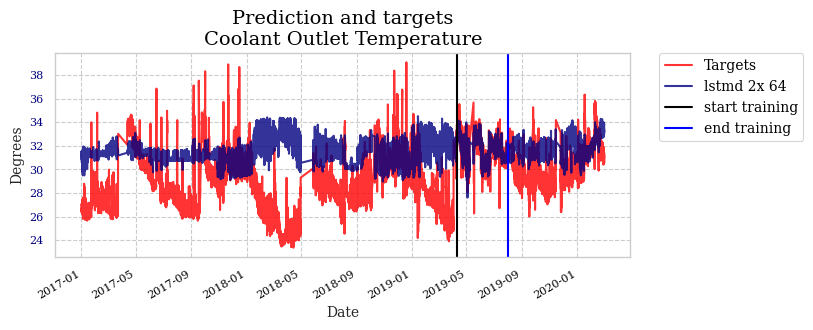

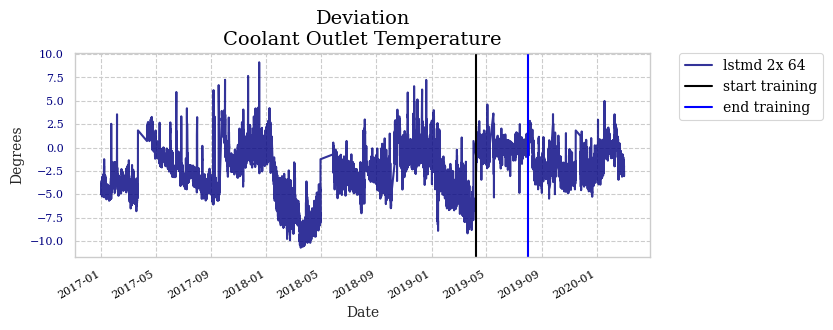

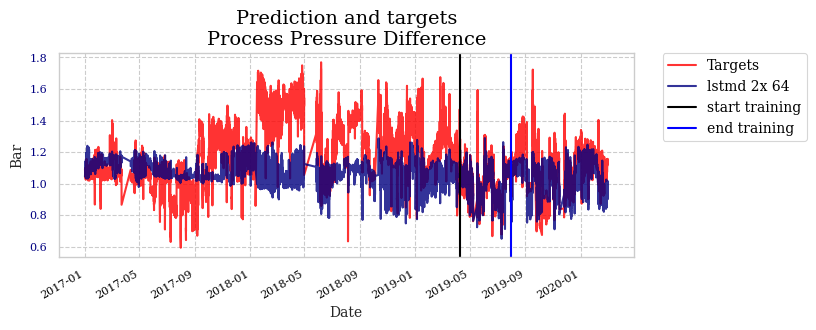

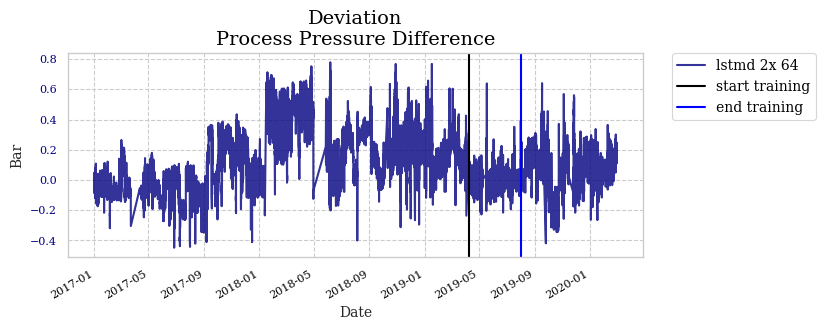

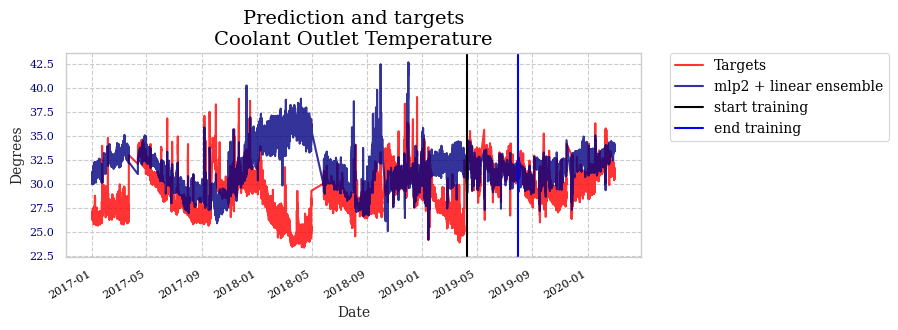

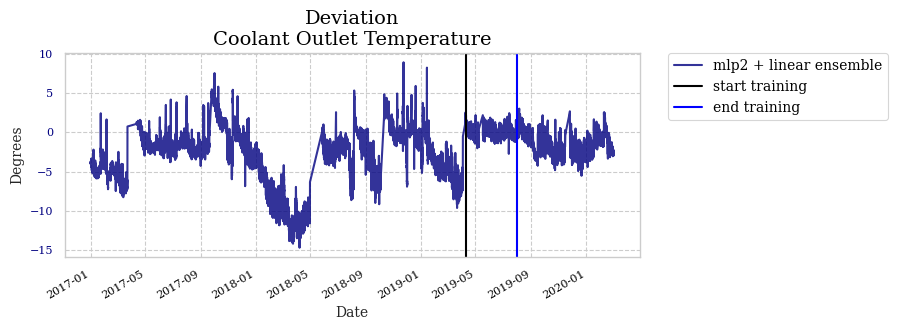

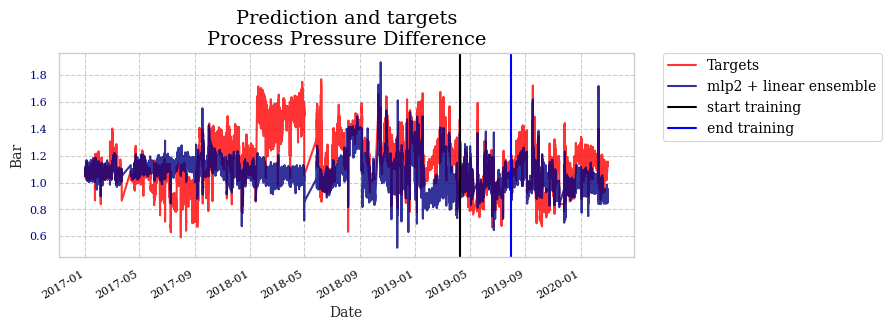

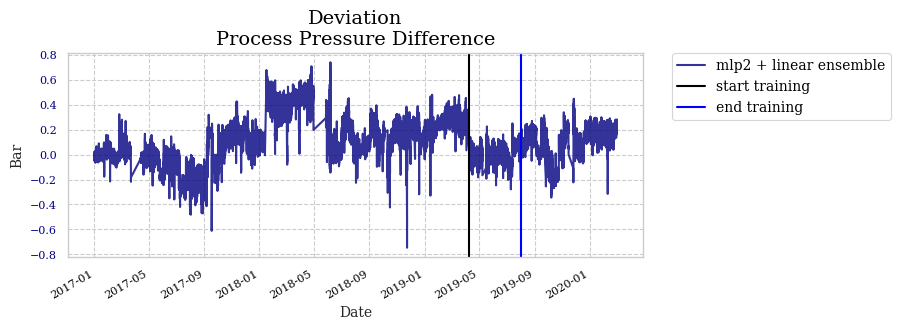

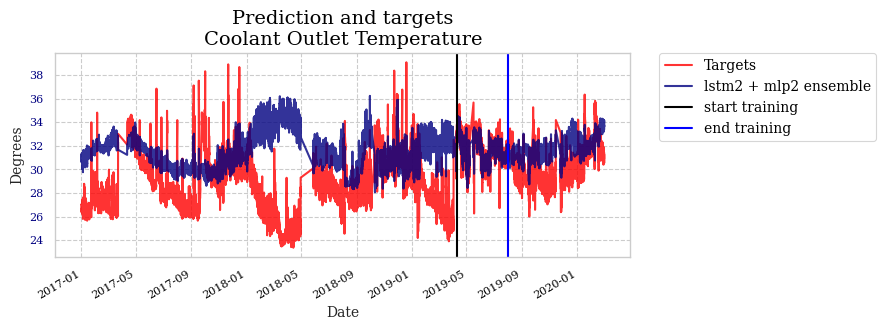

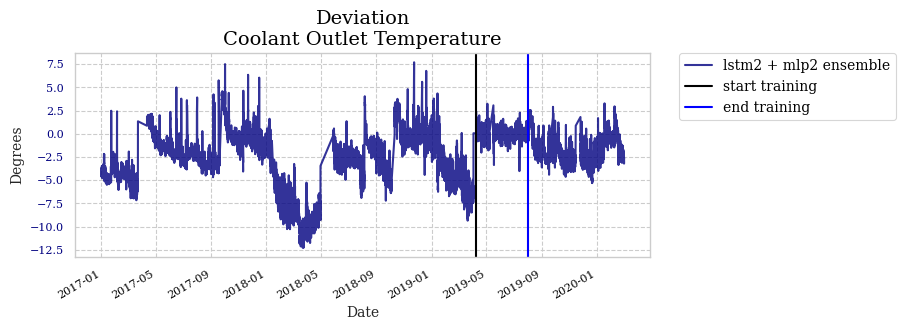

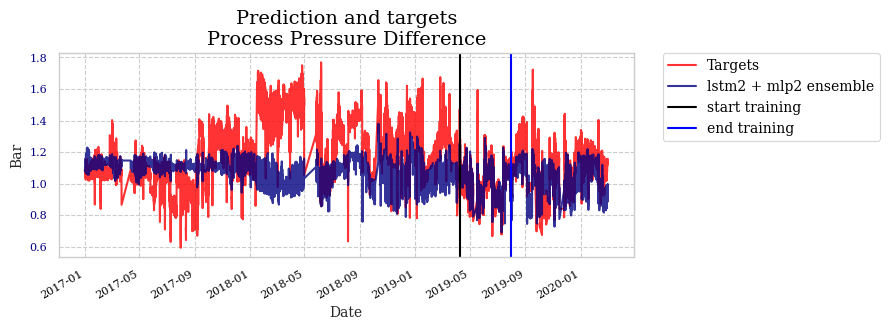

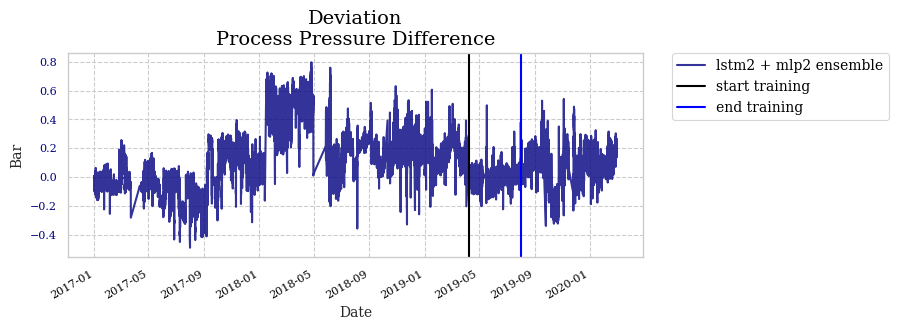

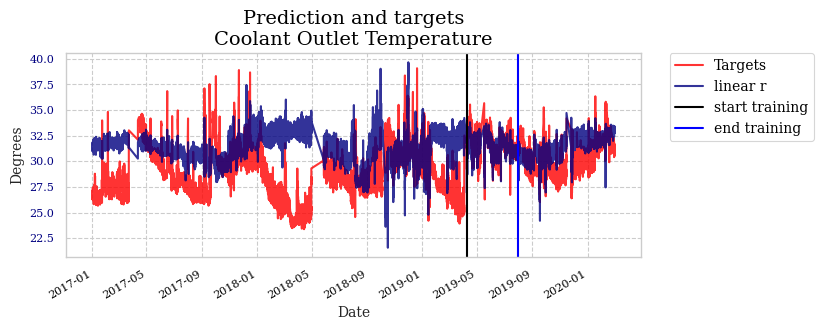

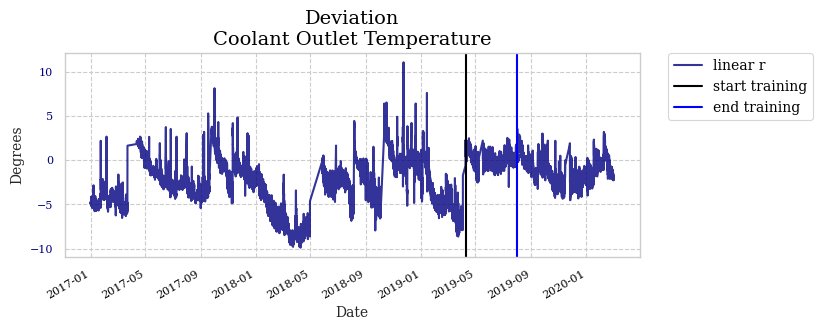

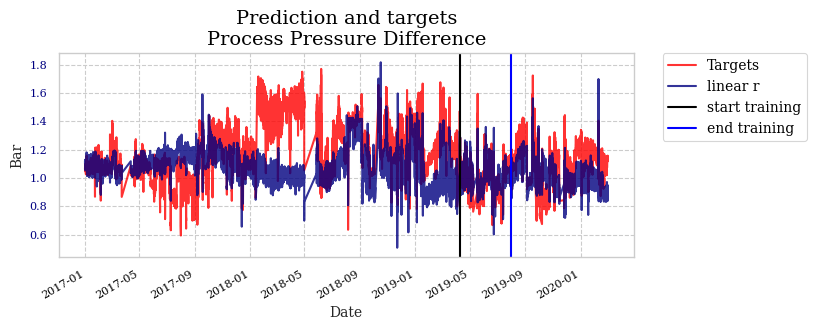

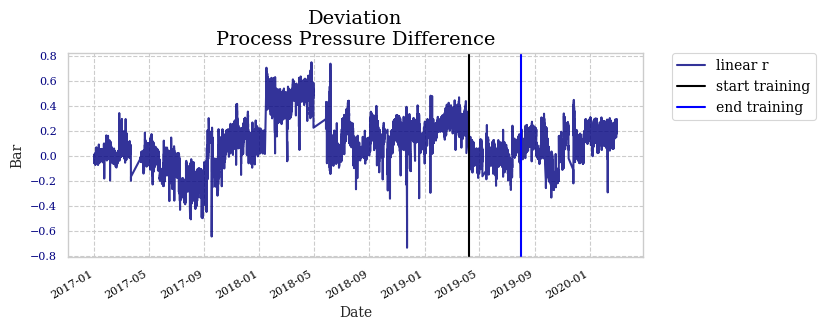

In [7]:
for model in modelList:
    mlApi.initModels([model])
    modelNames, metrics_train, metrics_test, columnsList, deviationsList = mlApi.predictWithModels(
        plot=True,
        interpol=False,
        score=False,
    )

# Conclusions

In general, the predictions of all models appear logical, with the exception of **mlp 2x 64** where a large increase in Coolant Outlet Temperature is predicted around 2018-05. Increases of deviation magnitude can clearly been seen before each heat exchanger maintenance notes in the thesis. Especially the linear model and the simplest LSTM model show promise, although the testing period spans a large timeframe and there is no guarantee that the training period is representative for the entirety of the testing period.

Deviation between predicted and measured Process Pressure Difference seems to increase during some periods of fouling, while remaining constant during others. In theory this would indicate coolant side fouling when the pressure difference remains constant and process side fouling when the pressure difference is increasing, however there is no way to know which type of fouling was present in the system at the time of maintenance. Most likely, the degree of process side fouling is small in relation to the cooling side fouling. Results here would indicate that Process Pressure Difference is not a suitable parameter for determining on which side of the system fouling is present, at least not without further investigation.